In [10]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../')
from mrcnn.utils import trim_zeros_graph
import numpy as np
import tensorflow as tf
import keras

import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 
from mrcnn.utils       import stack_tensors, stack_tensors_3d
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4)


# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 3                  # Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 3                  # Must match BATCH_SIZE
config.STEPS_PER_EPOCH = 2
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
config.display() 

# Build shape dataset        -----------------------------------------------
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()


# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

np.set_printoptions(linewidth=100, precision=4)
sess = tf.InteractiveSession()

batch_size = 3
num_rois = 32
num_classes = 4
num_detections = 100
num_rois_per_image = 32
rois_per_image = 32

train_generator = data_generator(dataset_train, config, shuffle=True,
                                 batch_size=config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, config, shuffle=True, 
                                batch_size=config.BATCH_SIZE,
                                augment=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow Version: 1.6.0   Keras Version : 2.1.4 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)


Image id:  112
Image meta [112 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 3]


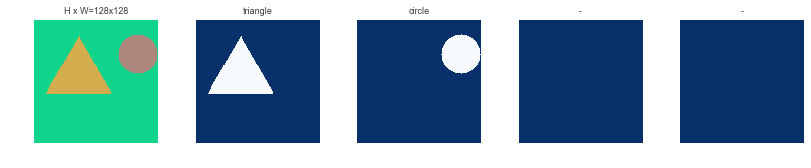

Image id:  169
Image meta [169 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 2 3]


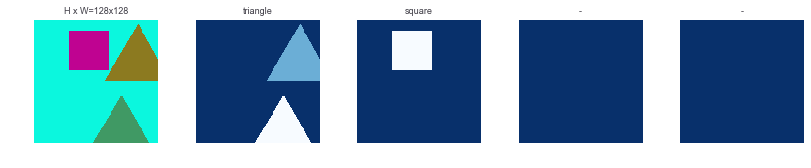

Image id:  7
Image meta [  7 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 2]


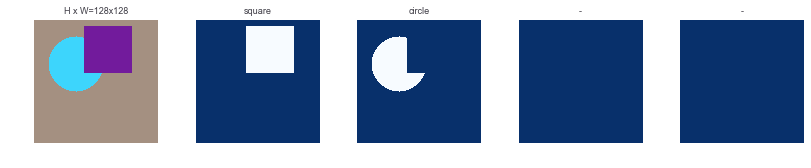

In [13]:
train_batch_x, train_batch_y = next(train_generator)


# train_batch_x, train_batch_y = next(train_generator)
# imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[1]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [17]:
gt_class_ids  = train_batch_x[4]
norm_gt_bboxes = train_batch_x[5]

In [34]:
print(norm_gt_bboxes[:,:5])

[[[ 16  87  57 128]
  [ 18  12  77  80]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  5  73  64 128]
  [ 12  36  53  77]
  [ 79  61 128 119]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[ 18  15  75  70]
  [  7  52  56 101]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]]


In [31]:
batch_size      = config.BATCH_SIZE
num_classes     = config.NUM_CLASSES
num_detections  = config.DETECTION_MAX_INSTANCES
h, w            = config.IMAGE_SHAPE[:2]
# num_cols        = 7 
print('\n')
print('  > BUILD_GROUND TRUTH_TF()' )
print('    gt_class_ids shape : ', gt_class_ids.shape, '    notm_gt_bbox.shape  : ', norm_gt_bboxes.shape )

# sess = tf.InteractiveSession()
gt_bboxes       = norm_gt_bboxes   ###   noot needed in this testing * np.array([h,w,h,w])   



  > BUILD_GROUND TRUTH_TF()
    gt_class_ids shape :  (3, 100)     notm_gt_bbox.shape  :  (3, 100, 4)


In [32]:
#---------------------------------------------------------------------------
# use the argmaxof each row to determine the dominating (predicted) class
#---------------------------------------------------------------------------

# gt_classes     = gt_class_ids    # batch_size x max gt detections
gt_classes_exp = tf.to_float(tf.expand_dims(gt_class_ids ,axis=-1))
print('    gt_classes_exp shape ', gt_classes_exp.get_shape() )

ones = tf.ones_like(gt_class_ids)
zeros= tf.zeros_like(gt_class_ids)
mask = tf.greater(gt_class_ids , 0)
print(mask.shape)
print(mask.eval())
gt_scores  =  tf.where(mask, ones, zeros)
# pred_scores      = tf.reduce_max(mrcnn_class ,axis=-1, keep_dims=True)   # (32,)
gt_scores_exp = tf.to_float(tf.expand_dims(gt_scores, axis=-1))
print('    pred_ scores shape ', gt_scores.get_shape())
print(gt_scores.eval())    
print

    gt_classes_exp shape  (3, 100, 1)
(3, 100)
[[ True  True False False False False False False False False False False False False False False
  False False False False False False False False False False False False False False False False
  False False False False False False False False False False False False False False False False
  False False False False False False False False False False False False False False False False
  False False False False False False False False False False False False False False False False
  False False False False False False False False False False False False False False False False
  False False False False]
 [ True  True  True False False False False False False False False False False False False False
  False False False False False False False False False False False False False False False False
  False False False False False False False False False False False False False False False False
  False False False False False False False 

<function print>

In [35]:
#---------------------------------------------------------------------------
# create meshgrid to do something 
#---------------------------------------------------------------------------
batch_grid, bbox_grid = tf.meshgrid( tf.range(batch_size    , dtype=tf.int32), 
                                     tf.range(num_detections, dtype=tf.int32), indexing = 'ij' )
print('    batch_grid shape  ', batch_grid.get_shape())
print(batch_grid.eval())
print('    bbox_grid  shape  ', bbox_grid.get_shape())
print(bbox_grid.eval())


bbox_idx_zeros  = tf.zeros_like(bbox_grid)
bbox_idx        = tf.where(mask, bbox_grid , bbox_idx_zeros)
bbox_idx        = tf.to_float(tf.expand_dims(bbox_idx, axis = -1))    

gt_array        = tf.concat([bbox_idx , gt_bboxes, gt_classes_exp, gt_scores_exp], axis=2)

np.set_printoptions(linewidth=100,precision=7)

print('    bbox_idx shape    ', bbox_idx.get_shape())
# print(bbox_idx.eval()) 
print('    gt_array shape    ', gt_array.get_shape())
print('    bbox_grid  shape  ', bbox_grid.get_shape())
# print(bbox_grid.eval())
print('    batch_grid shape  ', batch_grid.get_shape())
# print(batch_grid.eval())
    
print(gt_array[:,:10].eval())

    batch_grid shape   (3, 100)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2]]
    bbox_grid  shape   (3, 100)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
  32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
  64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
  96 97 98 99]
 [ 0 

In [36]:
scatter_ind = tf.stack([batch_grid , gt_class_ids, bbox_grid],axis = -1)
gt_scatter = tf.scatter_nd(scatter_ind, gt_array, [batch_size, num_classes, num_detections,7])


# print('-- stack results ----')
print('    scatter_ind shape ', scatter_ind.get_shape())
# print(scatter_ind.eval())
print('    gt_scatter shape ', gt_scatter.get_shape())


    scatter_ind shape  (3, 100, 3)
    gt_scatter shape  (3, 4, 100, 7)


In [38]:
print(gt_scatter[1,:,:5,:].eval())

[[[  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]]

 [[  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]]

 [[  0.   0.   0.   0.   0.   0.   0.]
  [  1.  12.  36.  53.  77.   2.   1.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]]

 [[  0.   5.  73.  64. 128.   3.   1.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  2.  79.  61. 128. 119.   3.   1.]
  [  0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.]]]


In [47]:
## sort in each class dimension based on y2 (column 1)
# scatter_nd places bboxs in a sparse fashion --- this sort is to place all bboxes
# at the top of the class bbox array
#-------------------------------------------------------------------------------

_ , sort_inds = tf.nn.top_k(gt_scatter[:,:,:,1], k=gt_scatter.shape[2])

# build gathering indexes to use in sorting 
class_grid, batch_grid, bbox_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_detections))
bbox_grid_exp = tf.to_float(tf.expand_dims(bbox_grid, axis = -1))

print('    build gathering indexes to use in sorting -------')    
print('    sort inds shape : ', sort_inds.get_shape())
print('    class_grid  shape ', class_grid.get_shape())
# print(class_grid.eval())
print('    batch_grid  shape ', batch_grid.get_shape())
# print(class_grid.eval())
print('    bbox_grid   shape ', bbox_grid.get_shape() , ' bbox_grid_exp shape ', bbox_grid_exp.get_shape())
# print(bbox_grid.eval())

gather_inds = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
gt_tensor   = tf.gather_nd(gt_scatter, gather_inds, name  = 'gt_tensor')
print('    gather_inds shape      : ', gather_inds.get_shape())
print('    gt_tensor (gathered)   : ', gt_tensor.get_shape())
print(gt_tensor[:,:,:3].eval())

    build gathering indexes to use in sorting -------
    sort inds shape :  (3, 4, 100)
    class_grid  shape  (3, 4, 100)
    batch_grid  shape  (3, 4, 100)
    bbox_grid   shape  (3, 4, 100)  bbox_grid_exp shape  (3, 4, 100, 1)
    gather_inds shape      :  (3, 4, 100, 3)
    gt_tensor (gathered)   :  (3, 4, 100, 7)
[[[[  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]]

  [[  0.  16.  87.  57. 128.   1.   1.]
   [  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]]

  [[  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]]

  [[  1.  18.  12.  77.  80.   3.   1.]
   [  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]]]


 [[[  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.]]

  [[  0.   0.   0.   0.   0.   0.   0.]
   [  0.   0.   0.   0.   0

In [46]:
# count based on pred score > 0 (changed from index 0 to -1 on 30-04-2018)    
gt_cls_cnt  = tf.count_nonzero(gt_tensor[:,:,:,-1],axis = -1, name = 'gt_cls_count')


print('    final gt_tensor shape  : ', gt_tensor.get_shape())
print('    final gt_cls_cnt shape : ', gt_cls_cnt.get_shape())
print(gt_cls_cnt.eval())
print('    complete')


    final gt_tensor shape  :  (3, 4, 100, 7)
    final gt_cls_cnt shape :  (3, 4)
[[0 1 0 1]
 [0 0 1 2]
 [0 1 1 0]]
    complete
